# ML challenge EUROSat classification

In this notebook wee train our own CNN and use it to predict over the test set. This was our initial approach to the challenge. We have tried multiple different variations of this notebook but ultimatively moved on from this approach to a Vision image transformer.

In [34]:
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
TRAIN_DIR = 'data/train'
VALIDATION_DIR = 'data/validate'
TEST_DIR = 'data/test'

In [36]:
eurosat_classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

# Training class distribution

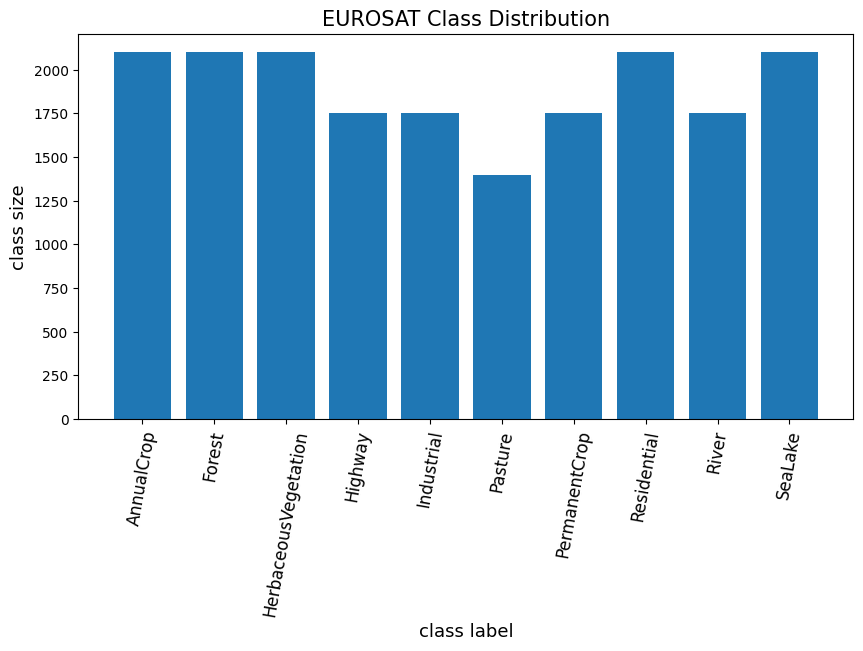

In [37]:
# plot class distributions of whole dataset
counts = {}

for l in eurosat_classes:
    counts[l] = len(os.listdir(os.path.join(TRAIN_DIR, l)))

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

## Custom Dataset

In [38]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, root, transform=None) -> None:
        super().__init__()
        self.transform = transform
        folder_names = [f.split("/")[-1] for f in glob.glob(root + "/*")]
        name_to_id = {name: id for (id, name) in enumerate(sorted(folder_names))}
        self.all_paths = glob.glob(root + "/*/*.tif")
        self.all_label = [name_to_id[path.split("/")[-2]] for path in self.all_paths]
    
    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, index):
        path_i = self.all_paths[index]
        with rio.open(path_i, "r") as d:
            image = d.read([3,2,1]).astype(np.float32)
            image = reshape_as_image(image)

        if self.transform is not None:
            image = self.transform(image)
            
        label = self.all_label[index]
        return image, label

> Mean and Std calculations and definition of the transformation for the training dataset

In [39]:
import torch
from torchvision.transforms import ToTensor

# # Create an instance of your dataset
# dataset = CustomDataset(root=TRAIN_DIR, transform=ToTensor())

# # Create a data loader for your dataset
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# # Compute the mean and std of the data
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in data_loader:
#     batch_samples = data[0].size(0)
#     data = data[0].view(batch_samples, data[0].size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print("Mean:", mean)
# print("Std:", std)


In [40]:
mean = [1041.2147, 1116.8573, 1353.4237]
std = [187.6871, 153.7980,  65.2661]
# training_transformations = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean,std)
# ])

training_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.GaussianBlur(1),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean, std)
])

test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



> loading the taining and validation set

In [41]:
train_dataset = CustomDataset(root=TRAIN_DIR, transform=training_transformations)
validation_dataset = CustomDataset(root=VALIDATION_DIR, transform=training_transformations)

len(train_dataset)

18900

In [42]:
# Set (random) image id
image_id = 500

# Retrieve image exhibiting the image id
train_dataset[58]

(tensor([[[-1.0188, -1.0135, -0.9069,  ..., -0.8643, -0.6618, -0.6618],
          [-1.0188, -1.0135, -0.9069,  ..., -0.8643, -0.6618, -0.6618],
          [-0.9229, -0.8323, -0.8110,  ..., -0.9708, -0.7364, -0.7364],
          ...,
          [-0.6831, -0.8856, -0.9495,  ..., -1.1094, -1.0241, -1.0241],
          [-0.9549, -0.9069, -1.0028,  ..., -0.7950, -1.0881, -1.0881],
          [-0.8643, -1.0081, -0.8909,  ..., -0.9708, -0.7258, -0.7258]],
 
         [[-2.1708, -2.1577, -2.1903,  ..., -1.9822, -2.0017, -2.0017],
          [-2.1708, -2.1577, -2.1903,  ..., -1.9822, -2.0017, -2.0017],
          [-2.1382, -2.1642, -2.1903,  ..., -2.1512, -2.0212, -2.0212],
          ...,
          [-2.0407, -1.9822, -1.9172,  ..., -2.0797, -2.1122, -2.1122],
          [-2.0212, -2.1122, -2.1252,  ..., -2.0537, -2.0862, -2.0862],
          [-2.0537, -2.0277, -2.0277,  ..., -2.1187, -1.9562, -1.9562]],
 
         [[-4.2966, -4.2966, -4.2966,  ..., -4.1281, -4.1128, -4.1128],
          [-4.2966, -4.2966,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


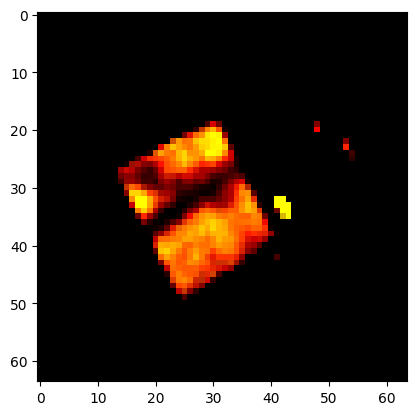

In [43]:
import numpy as np
import torch
import matplotlib.pyplot as plt

tensor_image = train_dataset[5680][0]

# display the tensor image using imshow()
image = tensor_image.permute(1, 2, 0)
print(tensor_image.shape)

print(image.shape)
plt.imshow(image)
plt.show()


In [44]:
eurosat_train_image, eurosat_train_label = train_dataset[image_id]

## CNN Model

In [45]:
import torch.nn as nn
import torch.nn.functional as F

In [46]:
class EuroSATNet(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(EuroSATNet, self).__init__()
        
        self.dropout_rate = dropout_rate
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=self.dropout_rate)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=self.dropout_rate)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=self.dropout_rate)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout2d(p=self.dropout_rate)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.linear4 = nn.Linear(128 * 3 * 3, 256)
        self.relu4 = nn.ReLU(inplace=True)
        
        self.linear5 = nn.Linear(256, 10)
        
    def forward(self, images):
        x = self.pool1(self.bn1(self.relu1(self.conv1(images))))
        x = self.dropout1(x)
        
        x = self.pool2(self.bn2(self.relu2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = self.pool3(self.bn3(self.relu3(self.conv3(x))))
        x = self.dropout3(x)
        
        x = self.pool4(self.bn4(self.relu4(self.conv4(x))))
        x = self.dropout4(x)
        
        x = x.view(-1, 128 * 3 * 3)
        
        x = self.relu4(self.linear4(x))
        x = self.linear5(x)

        return x


In [47]:
model = EuroSATNet()

In [48]:
print(model)

EuroSATNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [49]:
num_params = 0

# Iterate over the distinct parameters
for param in model.parameters():

    # Collect number of parameters
    num_params += param.numel()
    
# Print the number of model paramters
print('Number of to be trained EuroSATNet model parameters: {}.'.format(num_params))

Number of to be trained EuroSATNet model parameters: 403850.


> visualizing the weights of the first level before training

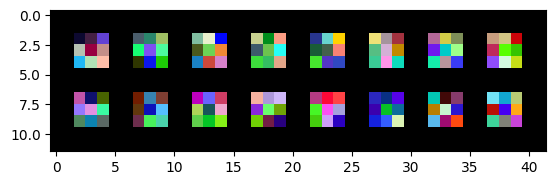

In [50]:
import torchvision

# Get the first convolutional layer
first_layer = model.conv1

# Get the weights of the first layer
weights = first_layer.weight.data.cpu()

# Create a grid of images from the weights
grid = torchvision.utils.make_grid(weights, normalize=True, scale_each=True)

# Visualize the grid
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [51]:
# Define the optimization criterion / loss function
cross_entropy = nn.CrossEntropyLoss()

In [52]:
# Define learning rate and optimization strategy
from torch import optim
learning_rate = 0.002
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

> here we specify the training parameters and train_loader and transfer the model to the compute device

In [53]:
# Specify the training parameters
num_epochs = 5 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

In [54]:
import torch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer model to compute device
model.to(device)

EuroSATNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [56]:
# Import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import tqdm

# Import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

## Training the model

In [57]:
# Init collection of training epoch losses
train_epoch_losses = []

# Set the model in training mode
model.train()

# Train for n epochs
for epoch in range(num_epochs):
    
    # Init collection of mini-batch losses
    train_mini_batch_losses = []
    
    train_loader_progress = tqdm.tqdm(train_loader)
    
    # Update for each min-batch
    for i, (x,y) in enumerate(train_loader_progress):

        # Transfer data to compute device
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        #x = x.float()
        pred = model(x)
        
        # Reset model's gradients
        model.zero_grad()
        
        # Compute loss
        loss = cross_entropy(pred, y)
        
        # Run backward pass
        loss.backward()
        
        # Update network paramaters
        optimizer.step()
        
        # Store mini-batch losses
        train_mini_batch_losses.append(loss.data.item())
        
        train_loader_progress.set_description(f"Loss: {loss.item():0.5f}")
        
        #np.seterr(divide='ignore', invalid='ignore')

    # Compute epoch loss
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    print(f"Epoch {epoch} - Loss: {train_epoch_loss:0.5f}") 

# Save final model 
torch.save(model.state_dict(), "checkpoint.pt")

Loss: 1.45656: 100%|██████████| 148/148 [03:11<00:00,  1.29s/it]


Epoch 0 - Loss: 1.67919


Loss: 1.47165: 100%|██████████| 148/148 [02:56<00:00,  1.19s/it]


Epoch 1 - Loss: 1.42269


Loss: 1.40420: 100%|██████████| 148/148 [03:10<00:00,  1.29s/it]


Epoch 2 - Loss: 1.31174


Loss: 1.24165: 100%|██████████| 148/148 [02:47<00:00,  1.13s/it]


Epoch 3 - Loss: 1.23187


Loss: 1.30074: 100%|██████████| 148/148 [02:42<00:00,  1.10s/it]

Epoch 4 - Loss: 1.15806


## Analysing the loss

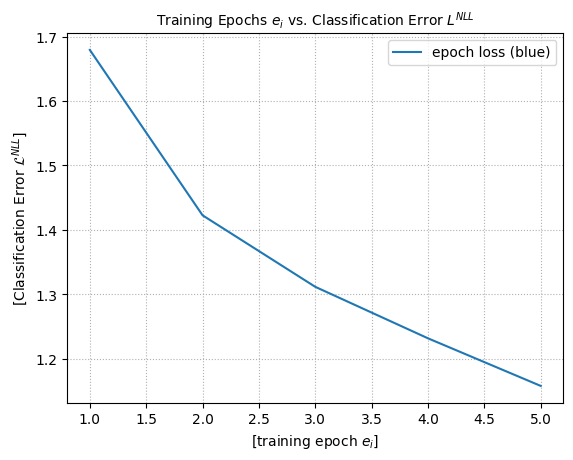

In [58]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

> Analysing the frist level after training

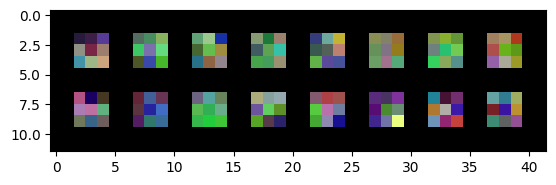

In [59]:
# Get the first convolutional layer
first_layer = model.conv1

# Get the weights of the first layer
weights = first_layer.weight.data.cpu()

# Create a grid of images from the weights
grid = torchvision.utils.make_grid(weights, normalize=True)

# Visualize the grid
plt.imshow(grid.permute(1, 2, 0))
plt.show()

In [60]:
# restore pre-trained model snapshot
best_model_name = 'checkpoint.pt'

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=device)

# init pre-trained model class
best_model = EuroSATNet()

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

In [61]:
# set model in evaluation mode
best_model.eval()

EuroSATNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [62]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10000, shuffle=False)

In [63]:
len(validation_dataset)

8100

In [64]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(validation_loader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = cross_entropy(output, labels)

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

print(f"Eval loss: {eval_loss}")

Eval loss: 0.819549560546875


In [65]:
# set (random) image id
image_id = 109

# retrieve image exhibiting the image id
eurosat_eval_image, eurosat_eval_label = validation_dataset[image_id]

In [66]:
eurosat_classes[eurosat_eval_label]

'Forest'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 64, 3])
torch.Size([64, 64, 3])


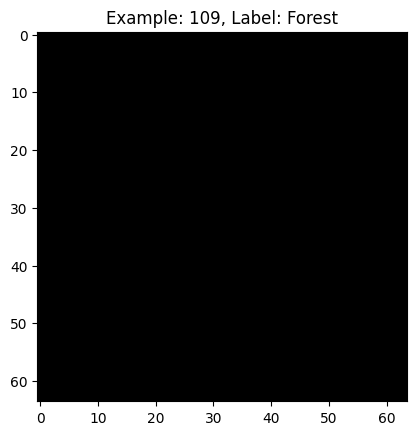

In [67]:
import numpy as np
import torch
import matplotlib.pyplot as plt



# display the tensor image using imshow()
image = eurosat_eval_image.permute(1, 2, 0)
print(image.shape)
#image = reshape_as_image(tensor_image)
#image = normalize_for_display(image)
#new_tensor = image[:, :, [3,2,1]]

print(image.shape)
plt.imshow(image)
plt.title('Example: {}, Label: {}'.format(str(image_id), str(eurosat_classes[eurosat_eval_label])))
plt.show()

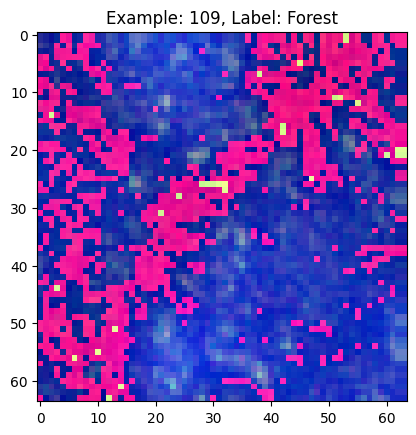

In [68]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), str(eurosat_classes[eurosat_eval_label])))

# un-normalize cifar 10 image sample
eurosat_eval_image_plot = eurosat_eval_image / 2.0 + 0.15

# plot cifar 10 image sample
plt.imshow(trans(eurosat_eval_image_plot))

In [69]:
eurosat_eval_image.unsqueeze(0).shape
best_model(eurosat_eval_image.unsqueeze(0))

tensor([[-1.0446,  5.0950,  1.5115, -3.3335, -9.3048,  0.8669, -1.9084, -4.1276,
         -0.9501,  3.0238]], grad_fn=<AddmmBackward0>)

In [70]:
eurosat_classes[torch.argmax(best_model(Variable(eurosat_eval_image.unsqueeze(0))), dim=1).item()]

'Forest'

In [71]:
print(validation_loader)

In [72]:
predictions = torch.argmax(best_model(next(iter(validation_loader))[0]), dim=1)

In [73]:
print(predictions[1500].item())
# predictions.shape
print(eurosat_classes[predictions[1500].item()])

0
AnnualCrop


In [74]:
metrics.accuracy_score(validation_dataset.all_label, predictions.detach())

0.7233333333333334

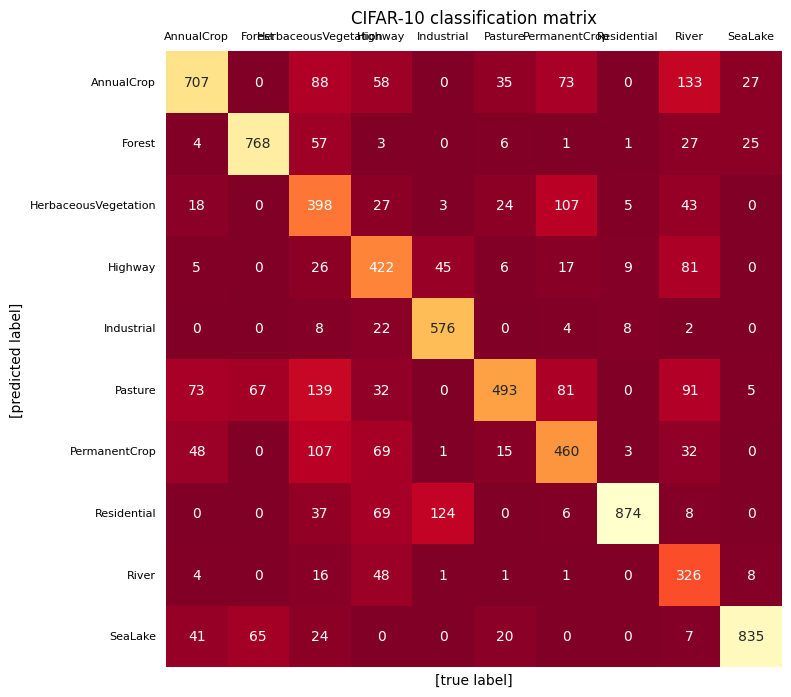

In [75]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(validation_dataset.all_label, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=eurosat_classes, yticklabels=eurosat_classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('CIFAR-10 classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

# Predict over test data

> defining and loading the Test Dataset

In [76]:
from torch.utils.data import Dataset
import glob

class TestDataset(Dataset):
    def __init__(self, root, transform=None) -> None:
        super().__init__()

        self.transform = transform
        files = os.listdir(root)
        self.root = root
        self.all_paths = sorted(files, key=lambda x: int(x.split("_")[1].split(".")[0]))
    
    def __len__(self):
        return len(self.all_paths)

    def __getitem__(self, index):
        path_i = os.path.join(self.root, self.all_paths[index])
        image = np.load(path_i).astype(np.float32)
        image = image[ :, :, [3,2,1]]
        
        if self.transform is not None:
            image = self.transform(image)
    
        return image


> Calculating mean and std and defining transformations for the test dataset

In [77]:
# # Create an instance of the TestDataset
# test_dataset = TestDataset(root=TEST_DIR, transform=ToTensor())

# # Calculate the mean and standard deviation of the dataset
# mean = 0.
# std = 0.
# num_samples = len(test_dataset)
# for data in test_dataset:
#     mean += data.mean([1, 2])
#     std += data.std([1, 2])

# mean /= num_samples
# std /= num_samples

# print('Mean: ', mean)
# print('Std: ', std)


In [78]:
mean = [578.8720, 628.8647, 400.1494]
std = [301.1053, 241.2066, 209.1485]
training_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
test_dataset = TestDataset(root=TEST_DIR, transform=test_transformations)

In [79]:
len(test_dataset)

4232

In [80]:
test_dataset[58]

tensor([[[ -4.5140,  -4.3595,  -4.3328,  ...,  -4.4447,  -4.5939,  -4.5459],
         [ -4.5406,  -4.5726,  -4.4447,  ...,  -4.4554,  -4.3168,  -4.4873],
         [ -4.0558,  -4.3115,  -4.5086,  ...,  -4.2955,  -4.1836,  -4.2849],
         ...,
         [ -4.3115,  -4.2263,  -4.2636,  ...,  -4.7644,  -4.6365,  -4.4234],
         [ -4.4873,  -4.4554,  -4.4287,  ...,  -4.6259,  -4.7484,  -4.7058],
         [ -4.5939,  -4.4127,  -4.5140,  ...,  -4.2689,  -4.3808,  -4.5566]],

        [[ -5.7989,  -5.6819,  -5.7209,  ...,  -5.6819,  -5.9094,  -5.9939],
         [ -5.7534,  -5.7339,  -5.5648,  ...,  -5.7079,  -5.7989,  -5.8444],
         [ -5.7664,  -5.6753,  -5.9679,  ...,  -5.4023,  -5.5258,  -5.7274],
         ...,
         [ -5.6753,  -5.5193,  -5.5843,  ...,  -5.8509,  -5.7924,  -5.5388],
         [ -5.7014,  -5.5843,  -5.5843,  ...,  -6.0525,  -5.9744,  -5.8509],
         [ -5.8379,  -5.6949,  -5.8054,  ...,  -5.6949,  -5.9094,  -6.0590]],

        [[-17.2896, -17.3356, -17.6420,  ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-1.5729, -2.1057, -3.9595],
         [-1.5729, -2.0992, -3.9749],
         [-1.5729, -2.0732, -3.9902],
         ...,
         [-2.0364, -2.3203, -3.4233],
         [-2.0578, -2.2163, -3.2394],
         [-2.0578, -2.2163, -3.2394]],

        [[-1.5729, -2.1057, -3.9595],
         [-1.5729, -2.0992, -3.9749],
         [-1.5729, -2.0732, -3.9902],
         ...,
         [-2.0364, -2.3203, -3.4233],
         [-2.0578, -2.2163, -3.2394],
         [-2.0578, -2.2163, -3.2394]],

        [[-1.5676, -2.0277, -3.9595],
         [-1.5623, -2.0017, -3.9749],
         [-1.5409, -2.0212, -3.9902],
         ...,
         [-2.0737, -2.2878, -3.5765],
         [-2.0524, -2.3398, -3.4233],
         [-2.0524, -2.3398, -3.4233]],

        ...,

        [[-1.0721, -1.7936, -3.4846],
         [-0.9655, -1.7611, -3.4692],
         [-0.9335, -1.6441, -3.4539],
         ...,
         [-1.8020, -2.0667, -3.7757],
         [-1.7114, -2.0407, -3.7757],
         [-1.7114, -2.0407, -3.7757]],

        [[

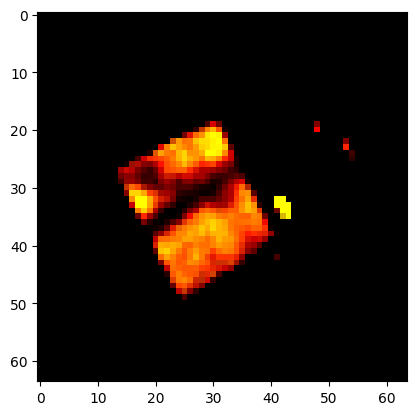

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt

new_tensor = test_dataset[4025]

# display the tensor image using imshow()
new_tensor = tensor_image.permute(1, 2, 0)

print(new_tensor)
plt.imshow(new_tensor)
plt.show()

> predicting over the test set

In [82]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
predictionsTest = torch.argmax(best_model(next(iter(test_loader))), dim=1)
print(predictionsTest)


tensor([0, 0, 9,  ..., 0, 3, 9])


In [83]:
classArray = []
for i in range(len(predictionsTest)):
    c = eurosat_classes[predictionsTest[i].item()]
    classArray.append(c)


# Export submission csv

In [84]:
import csv

with open('submission_cnn.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['test_id', 'label'])

    # Write each string to a row with its corresponding index as the test_id
    for i, label in enumerate(classArray):
        writer.writerow([i, label])